
##Data Preprocessing

*   Setting up the Notebook, importing the libraries
*   Loading the data, visualizing it, check the size of the images
*   Process them
*   Create pipeline for YOLO implementation





###Setting up this Google Colab Notebook


In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import os

#os.chdir allows you to change directories, like cd in the Terminal
#os.chdir('/content/drive/MyDrive/LeWagon/Notebook')

###Importing the necessary libraries

In [73]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [74]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import os

In [75]:
import tensorflow as tf
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
import keras_cv

In [77]:
# import os
# # Create local folder for data to unzip to
#os.mkdir('data')

In [78]:
!unzip '/content/drive/MyDrive/Colab Notebooks/data/images.zip' -d '/content/data/'


Archive:  /content/drive/MyDrive/Colab Notebooks/data/images.zip
replace /content/data/bbox_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
!ls

data  drive  sample_data  yolo_data


### Listing our images

In [80]:
test_image_folder = '/content/data/image_data'
test_image_files = os.listdir(test_image_folder)
test_image_files = test_image_files[:10]  # Only take the first 10 images

### Data vizualisation

###Loading annotations for our images

In [81]:
path_annot = '/content/data/bbox_train.csv'
df = pd.read_csv(path_annot)

In [82]:
# Lets make the folder where we will store all the data in YOLO format
# os.mkdir('yolo_data')
# os.mkdir('yolo_data/train')
# os.mkdir('yolo_data/test')
# os.mkdir('yolo_data/val')

In [83]:
# We want to take data from this df and covert it to yolo format
# On this link we see allowed options https://keras.io/api/keras_cv/bounding_box/formats/
# One of them:
#REL_XYXY class
#keras_cv.bounding_box.REL_XYXY()
#REL_XYXY contains axis indices for the REL_XYXY format.

#REL_XYXY is like XYXY, but each value is relative to the width and height of the origin image. Values are percentages of the origin images' width and height respectively.

#The REL_XYXY format consists of the following required indices:

#LEFT: left of the bounding box
#TOP: top of the bounding box
#RIGHT: right of the bounding box
#BOTTOM: bottom of the bounding box
# Convert to REL_XYXY format

df['LEFT'] = df['xmin'] / df['width']
df['TOP'] = df['ymin'] / df['height']
df['RIGHT'] = df['xmax'] / df['width']
df['BOTTOM'] = df['ymax'] / df['height']

# Selecting only the required columns
df_rel_xyxy = df[['Name', 'LEFT', 'TOP', 'RIGHT', 'BOTTOM']]

#Now we have all columns in the correct format
df_rel_xyxy.head()

,Name,LEFT,TOP,RIGHT,BOTTOM
0,10001.jpg,0.313725,0.487745,0.375817,0.575980
1,10001.jpg,0.403595,0.411765,0.475490,0.517157
2,10001.jpg,0.524510,0.431373,0.598039,0.544118
3,10001.jpg,0.580065,0.448529,0.632353,0.524510
4,10002.jpg,0.553922,0.404412,0.617647,0.495098


In [84]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split



# Define paths
src_folder = "/content/data/image_data"
train_folder = "/content/yolo_data/train/images"
val_folder = "/content/yolo_data/val/images"
test_folder = "/content/yolo_data/test/images"
train_label_folder = "/content/yolo_data/train/labels"
val_label_folder = "/content/yolo_data/val/labels"
test_label_folder = "/content/yolo_data/test/labels"
all_files_images = "/content/yolo_data/all_files/images"
all_files_labels = "/content/yolo_data/all_files/labels"

# Creating necessary directories if they don't exist
for folder in [train_folder, val_folder, test_folder, train_label_folder, val_label_folder, test_label_folder, all_files_images, all_files_labels]:
    os.makedirs(folder, exist_ok=True)


def move_files(df, target_folder, target_label_folder):
    for _, row in df.iterrows():
        # Moving image files
        src_path = os.path.join(src_folder, row['Name'])
        dst_path = os.path.join(target_folder, row['Name'])
        shutil.copy(src_path, dst_path)

        # Calculating bounding box center, width, and height
        x_center = (row['LEFT'] + row['RIGHT']) / 2
        y_center = (row['TOP'] + row['BOTTOM']) / 2
        width = abs(row['RIGHT'] - row['LEFT'])
        height = abs(row['BOTTOM'] - row['TOP'])

        # Writing label files in append mode
        label_path = os.path.join(target_label_folder, row['Name'].replace('.jpg', '.txt'))
        with open(label_path, 'a') as file:  # Use 'a' for append mode.0
            file.write(f"0 {x_center} {y_center} {width} {height}\n")


# Moving and creating label files
move_files(df_rel_xyxy, all_files_images, all_files_labels)


In [85]:
all_images = os.listdir(all_files_images)
all_labels = os.listdir(all_files_labels)
# Now everyting is inside of two folders, which you have to further spread into train - val - test
train_idx = int(len(all_images)* 0.8)
validation_idx = int(len(all_images)* 0.15)
test_idx = len(all_images) - train_idx - validation_idx


In [86]:
train_set = all_images[:train_idx]
validation_set = all_images[train_idx:train_idx+validation_idx]
test_set = all_images[train_idx+validation_idx:]

In [87]:
# Define a function to aggregate bounding box coordinates for each image.
def aggregate_boxes(data):
    boxes = data[['LEFT', 'TOP', 'RIGHT', 'BOTTOM']].values.tolist()
    return boxes

# Apply the aggregate function to the grouped data and reset the index.
grouped = df_rel_xyxy.groupby('Name').apply(aggregate_boxes).reset_index(name='boxes')
grouped.head()

,Name,boxes
0,10001.jpg,"[[0.3137254901960784, 0.4877450980392157, 0.37..."
1,10002.jpg,"[[0.553921568627451, 0.40441176470588236, 0.61..."
2,10003.jpg,"[[0.08823529411764706, 0.015665796344647518, 0..."
3,10004.jpg,"[[0.22549019607843138, 0.4692874692874693, 0.3..."
4,10006.jpg,"[[0.2875816993464052, 0.3897058823529412, 0.36..."


In [88]:
image_paths = []
bboxes = []

# Iterate through the grouped dataframe and populate the lists with image paths and bounding boxes.
for _, row in grouped.iterrows():
    image_path = os.path.join(test_image_folder, row['Name'])
    image_bboxes = row['boxes']
    image_paths.append(image_path)
    bboxes.append(image_bboxes)

In [89]:
bboxes[0]

[[0.3137254901960784,
  0.4877450980392157,
  0.3758169934640523,
  0.5759803921568627],
 [0.4035947712418301,
  0.4117647058823529,
  0.47549019607843135,
  0.5171568627450981],
 [0.5245098039215687,
  0.43137254901960786,
  0.5980392156862745,
  0.5441176470588235],
 [0.5800653594771242,
  0.4485294117647059,
  0.6323529411764706,
  0.5245098039215687]]

In [90]:
image_paths[0]

'/content/data/image_data/10001.jpg'

In [91]:
# Convert the lists to TensorFlow tensors. Use a ragged tensor for bounding boxes to handle varying lengths.
bbox = tf.ragged.constant(bboxes, dtype=tf.float32)  # Bounding boxes
classes = tf.ragged.constant([[0] * len(b) for b in bboxes], dtype=tf.int32)  # Class labels
image_paths = tf.constant(image_paths)  # Image paths

In [92]:
# Function to load images without resizing, resize later
def load_image(image_path):
    # Read the image file and decode it to a tensor
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [93]:
load_image('/content/data/image_data/10001.jpg')

<tf.Tensor: shape=(408, 612, 3), dtype=uint8, numpy=
array([[[255, 250, 255],
        [248, 243, 249],
        [245, 242, 235],
        ...,
        [217, 234, 244],
        [156, 175, 179],
        [199, 222, 216]],

       [[251, 250, 255],
        [255, 255, 250],
        [255, 255, 241],
        ...,
        [237, 254, 255],
        [161, 178, 194],
        [ 77,  97, 106]],

       [[254, 255, 250],
        [248, 252, 237],
        [254, 255, 237],
        ...,
        [206, 227, 222],
        [118, 141, 133],
        [ 45,  68,  60]],

       ...,

       [[158, 179, 104],
        [186, 197, 163],
        [206, 222, 159],
        ...,
        [ 58,  62,   3],
        [ 59,  68,   3],
        [ 58,  71,   1]],

       [[157, 173, 128],
        [177, 193, 128],
        [173, 194,  73],
        ...,
        [ 57,  77,  14],
        [ 51,  76,  10],
        [ 42,  67,   0]],

       [[159, 168, 149],
        [170, 191,  90],
        [150, 178,   6],
        ...,
        [ 66,  99,  6

In [94]:
# Function to create the data dictionary required by KerasCV without resizing the image
def load_dataset(image_path, bbox, classes):
    # Load the image
    image = load_image(image_path)
    # Create a dictionary for bounding boxes with 'boxes' and 'classes' as keys
    bounding_boxes = {'boxes': bbox, 'classes': classes}
    # Return a dictionary with 'images' and 'bounding_boxes'
    return {'images': image, 'bounding_boxes': bounding_boxes}

In [95]:
# Create a tf.data.Dataset that combines the image paths with bounding boxes and class labels
data = tf.data.Dataset.from_tensor_slices((image_paths, bbox, classes))

In [96]:
# Apply the loading and preprocessing function to each element in the dataset
#data = data.map(load_dataset)

In [97]:
# for example in data.take(1):
#     print(example)

In [98]:
# import matplotlib.pyplot as plt

# for example in data.take(1):
#     image = example['images'].numpy()

# plt.imshow(image)
# plt.show()

In [123]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="rel_xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="rel_xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="rel_xyxy"
        ),
    ]
)

In [124]:
# train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.shuffle(BATCH_SIZE * 4)
# train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [125]:
len(data)

5733

In [126]:
train_idx = int(len(all_images)* 0.8)
validation_idx = int(len(all_images)* 0.15)
test_idx = len(all_images) - train_idx - validation_idx

In [127]:
train_data = data.take(train_idx)
val_data = data.skip(train_idx).take(validation_idx)
test_data = data.skip(train_idx + validation_idx)

In [128]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [129]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [130]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="rel_xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [131]:
# Define the class ids and mapping. In this case, we have only one class 'face'.
class_ids = ["face"]
class_mapping = {0: "face"}

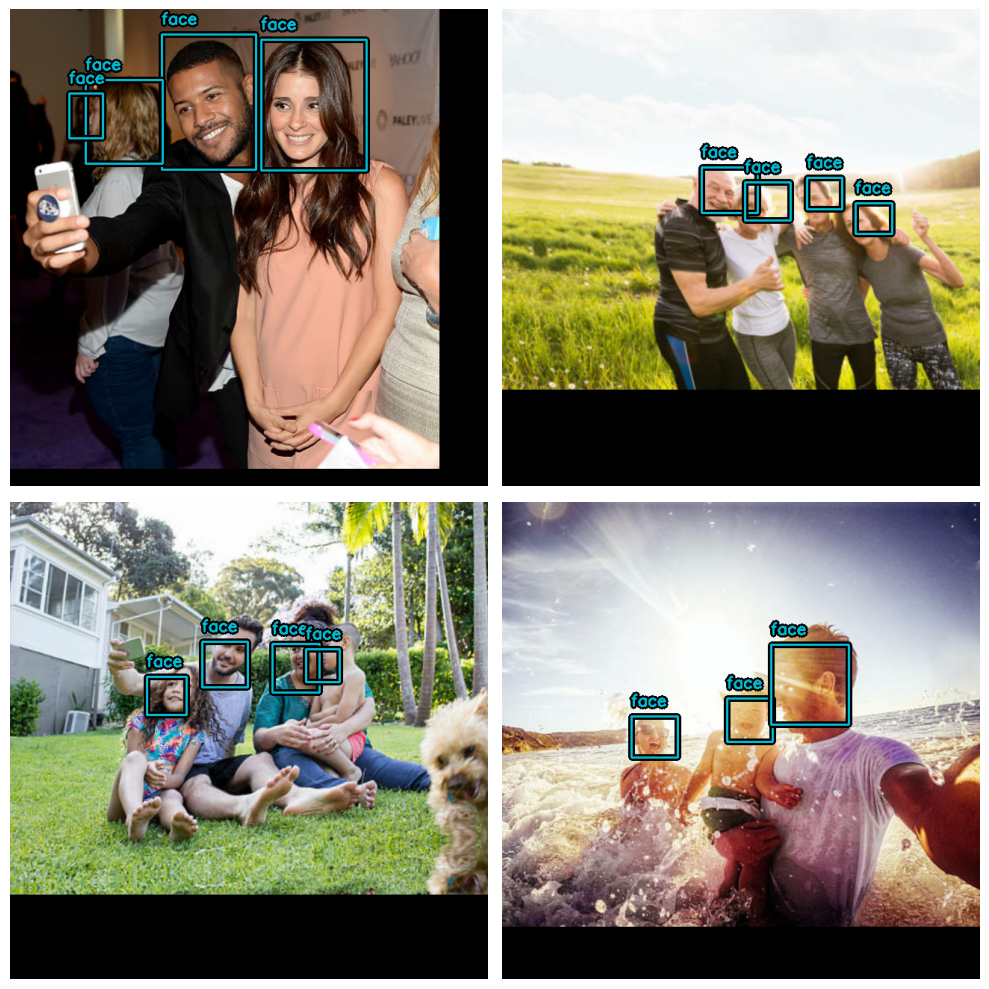

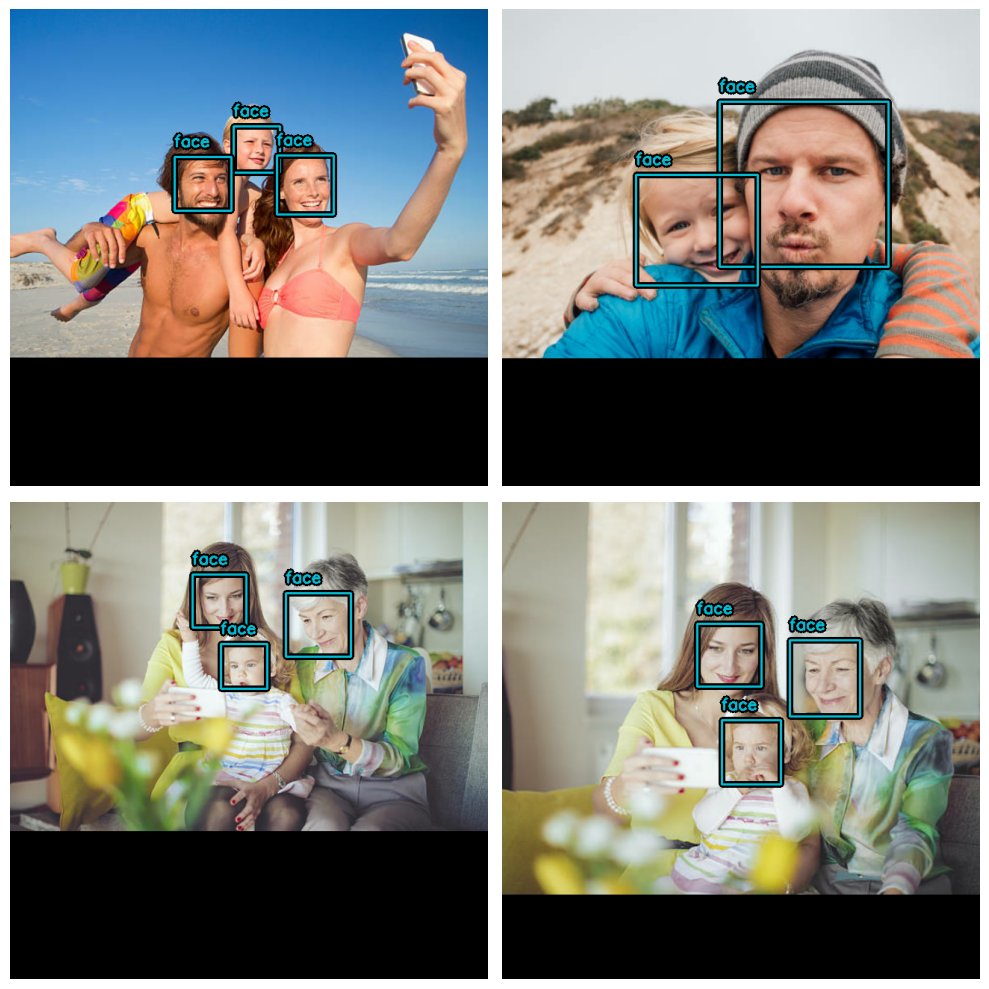

In [132]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="rel_xyxy", value_range=(0, 255), rows=2, cols=2
)

In [133]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
